In [5]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [6]:
# 📥 2. Load and Inspect Data
df = pd.read_csv("Train.csv")

# Convert date
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
df = df.sort_values("Date").reset_index(drop=True)

# View sample
df.head()


,Date,Category,Brand,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price,Sales_Quantity
0,2021-01-21,Toys,BrandF,3,0,5.1,473.60,6.21,427.60,350.0
1,2021-01-21,Sports,BrandD,3,0,30.7,385.47,32.28,383.25,436.0
2,2021-01-21,Sports,BrandD,3,0,28.4,116.88,17.83,395.65,136.0
3,2021-01-21,Electronics,BrandA,3,0,95.6,332.66,25.60,305.27,359.0
4,2021-01-21,Beauty,BrandC,3,0,35.8,119.34,33.46,138.57,133.0


In [7]:
# 🔍 3. Data Cleaning
# Check for missing target values
print("Missing values:\n", df.isnull().sum())

# Fill missing target (Sales_Quantity) with median instead of dropping
df["Sales_Quantity"].fillna(df["Sales_Quantity"].median(), inplace=True)


Missing values:
 Date                      0
Category                  0
Brand                     0
Day_of_Week               0
Holiday_Indicator         0
Past_Purchase_Trends      0
Price                     0
Discount                  0
Competitor_Price          0
Sales_Quantity          464
dtype: int64


In [8]:
# 🧠 4. Feature Engineering

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["Category", "Brand"], drop_first=True)

# Extract temporal features
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Year"] = df["Date"].dt.year
df["Weekday"] = df["Date"].dt.weekday
df["Is_Weekend"] = df["Weekday"].isin([5,6]).astype(int)

# Add lag features (shifted sales quantities)
df["Sales_Lag_1"] = df["Sales_Quantity"].shift(1)
df["Sales_Lag_7"] = df["Sales_Quantity"].shift(7)

# Rolling mean features
df["Sales_MA_7"] = df["Sales_Quantity"].rolling(window=7).mean()
df["Sales_MA_14"] = df["Sales_Quantity"].rolling(window=14).mean()

# Drop rows with NaNs (from shifting and rolling)
df.dropna(inplace=True)

# Drop date column (already encoded)
df.drop(columns=["Date"], inplace=True)

df.reset_index(drop=True, inplace=True)
df.head()


,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price,Sales_Quantity,Category_Beauty,Category_Books,Category_Clothing,...,Brand_BrandF,Month,Day,Year,Weekday,Is_Weekend,Sales_Lag_1,Sales_Lag_7,Sales_MA_7,Sales_MA_14
0,3,0,72.4,387.60,49.73,440.22,462.0,False,False,False,...,False,1,21,2021,3,0,120.0,82.0,292.857143,286.000000
1,3,0,34.0,464.65,43.42,86.02,41.0,False,False,False,...,False,1,21,2021,3,0,462.0,445.0,235.142857,263.928571
2,3,0,40.9,243.66,48.74,254.32,260.0,False,False,False,...,False,1,21,2021,3,0,41.0,268.0,234.000000,251.357143
3,3,0,8.7,99.64,18.52,129.23,308.0,True,False,False,...,False,1,21,2021,3,0,260.0,189.0,251.000000,263.642857
4,3,0,13.0,58.44,37.90,197.86,250.0,True,False,False,...,False,1,21,2021,3,0,308.0,477.0,218.571429,255.857143


In [9]:
# 📊 5. Define Features and Target
X = df.drop("Sales_Quantity", axis=1)
y = df["Sales_Quantity"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
# 🤖 6. Train Model
model = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [15]:
# 📏 7. Evaluation Metrics (with accuracy from R²)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # fixed for older sklearn
r2 = r2_score(y_test, y_pred)

# Accuracy as R² expressed in percentage
accuracy = r2 * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Accuracy (R² %): {accuracy:.2f}%")


MAE: 106.80
RMSE: 127.62
R² Score: 0.16
Accuracy (R² %): 16.03%


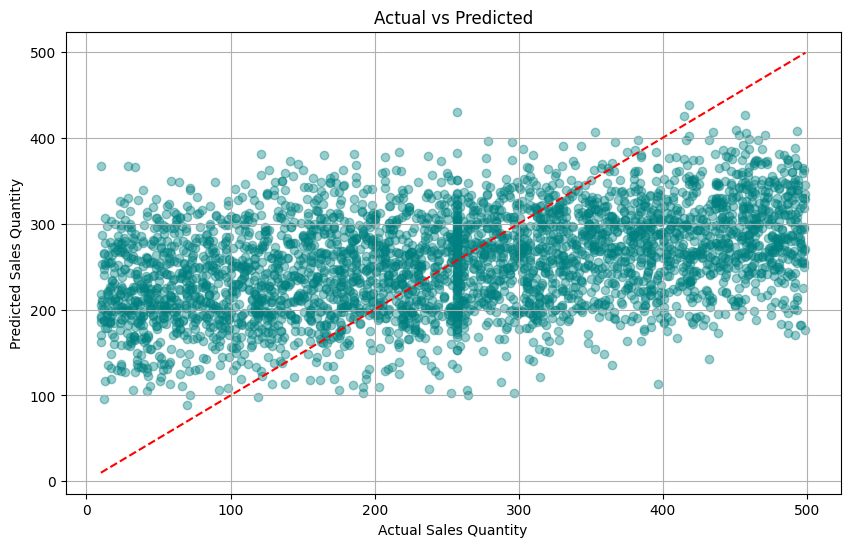

In [13]:
# 📈 8. Visualizations

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Sales Quantity")
plt.ylabel("Predicted Sales Quantity")
plt.title("Actual vs Predicted")
plt.grid()
plt.show()


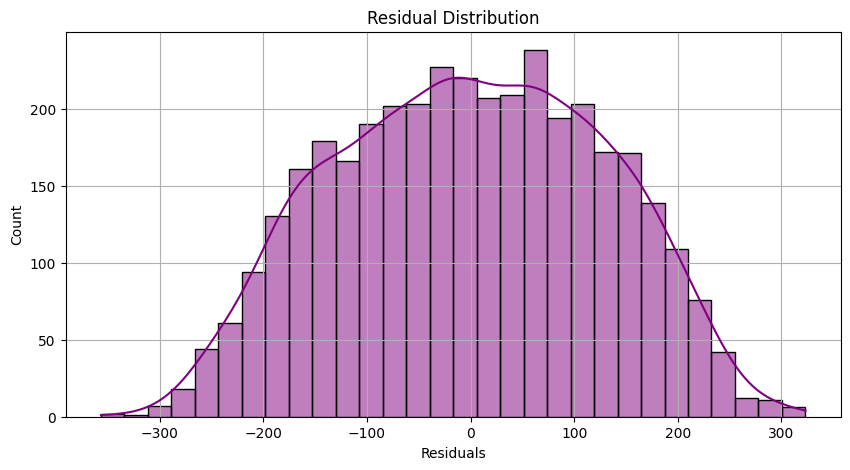

In [14]:
# Residual Distribution
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.grid()
plt.show()
